In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import copy
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple

import celeri

plt.rcParams[
    "text.usetex"
] = False  # Plotting the global model is much much faster with tex fonts turned off

# Read in data files, create storage dictionaries, and do basic processing

In [3]:
# Western North America example
command_file_name = "../data/command/western_north_america_command.json"

In [4]:
command = celeri.get_command(command_file_name)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(
    assembly, station, sar
)  # Not sure this works correctly

2023-12-28 20:13:21.734 | INFO     | celeri.celeri:get_logger:122 - Read: ../data/command/western_north_america_command.json
2023-12-28 20:13:21.734 | INFO     | celeri.celeri:get_logger:123 - RUN_NAME: 2023-12-28-20-13-21
2023-12-28 20:13:21.734 | INFO     | celeri.celeri:get_logger:124 - Write log file: ../runs/2023-12-28-20-13-21/2023-12-28-20-13-21.log
2023-12-28 20:13:21.735 | INFO     | celeri.celeri:read_data:129 - Reading data files
2023-12-28 20:13:21.740 | SUCCESS  | celeri.celeri:read_data:133 - Read: ../data/segment/western_north_america_segment.csv
2023-12-28 20:13:21.741 | SUCCESS  | celeri.celeri:read_data:138 - Read: ../data/block/western_north_america_block.csv
2023-12-28 20:13:21.742 | SUCCESS  | celeri.celeri:read_data:145 - Read: ../data/mesh/western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

2023-12-28 20:13:21.801 | SUCCESS  | celeri.celeri:read_data:266 - Read: ../data/mesh/cascadia.msh
2023-12-28 20:13:21.807 | SUCCESS  | celeri.celeri:read_data:302 - Read: ../data/station/western_north_america_station.csv
2023-12-28 20:13:21.808 | INFO     | celeri.celeri:read_data:317 - No mogi_file_name
2023-12-28 20:13:21.809 | INFO     | celeri.celeri:read_data:339 - No sar_file_name


# Get elastic operators and TDE smoothing operators

In [5]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

2023-12-28 20:13:22.516 | INFO     | celeri.celeri:get_elastic_operators:1525 - Using precomputed elastic operators


# Calculate non-elastic operators

In [6]:
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, len(block)
)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(
    station
)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)
(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)
celeri.get_tde_slip_rate_constraints(meshes, operators)

2023-12-28 20:13:23.122 | INFO     | celeri.celeri:get_slip_rate_constraints:1164 - Found 1 slip rate constraints
2023-12-28 20:13:23.126 | INFO     | celeri.celeri:get_slip_rate_constraints:1167 - Strike-slip rate constraint on cfm_san_andreas_mojave_extruded_trace_part1_sa: rate = -50.00 (mm/yr), 1-sigma uncertainty = +/-1.00 (mm/yr)


# Plot input data

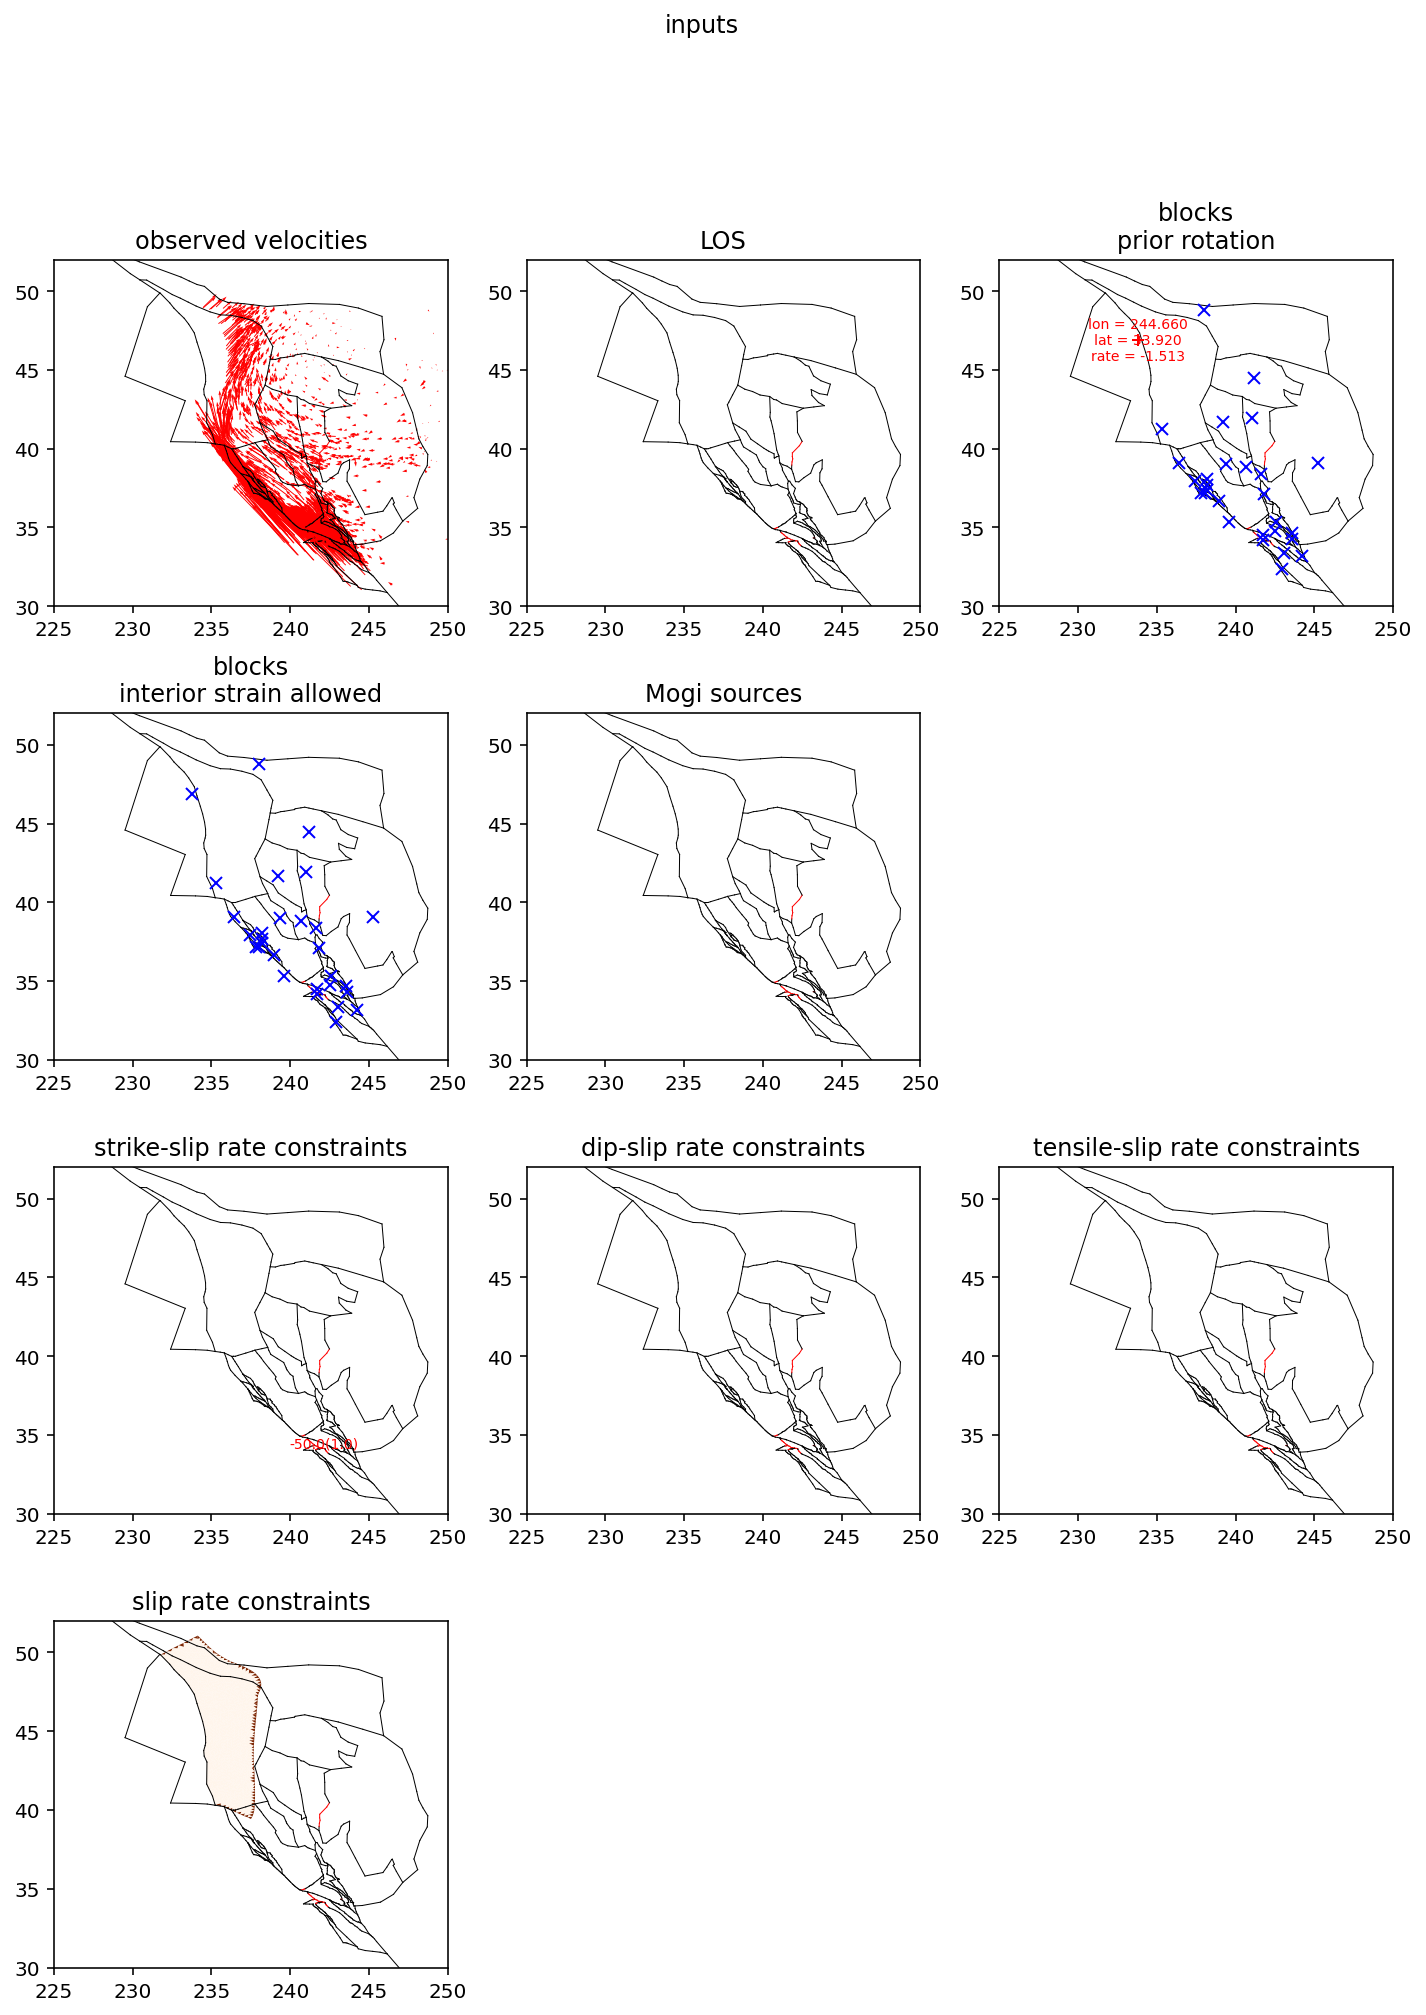

2023-12-28 20:13:26.746 | SUCCESS  | celeri.celeri:plot_input_summary:4085 - Wrote figures../runs/2023-12-28-20-13-21/plot_input_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [7]:
celeri.plot_input_summary(
    command,
    segment,
    station,
    block,
    meshes,
    mogi,
    sar,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=1e2,
)

# Sketching out the assembly of the block model system

$$
\begin{bmatrix}
    \mathrm{geodetic \; velocities} \\
    \mathrm{plate \; rotation \; constraints} \\
    \mathrm{slip \; rate \; constraints} \\
    \mathrm{TDE \; smoothing \; pseudodata = 0} \\
    \mathrm{TDE \; rate \; constraints} \\
    \mathrm{InSAR \; LOS \; changes} 
\end{bmatrix}
=
\begin{bmatrix}
    \mathrm{(rotations-elastic \; segments) \; to \; velocities} & \mathrm{TDEs \; to \; velocities} & \mathrm{block \; strain \; rate \; to \; velocities} & \mathrm{Mogi \; to \; velocities}\\
    \mathrm{identities}                                          & 0                                   & 0 \\
    \mathrm{plate \; rotations \; to \; slip \; rates}           & 0                                   & 0 \\
    0                                                            & \mathrm{TDE \; smoothing \; matrix} & 0 \\
    0                                                            & \mathrm{identities}                 & 0 \\
    \mathrm{(rotations-elastic \; segments) \; to \; LOS}        & \mathrm{TDEs \; to \; LOS}          & \mathrm{block \; strain \; rate \; to \; velocities}
\end{bmatrix}
\begin{bmatrix}
    \mathrm{plate \; rotation \; rates} \\
    \mathrm{TDE \; slip \; rates} \\
    \mathrm{block \; strain \; rates} \\
    \mathrm{Mogi \; rates}
\end{bmatrix}
$$

# Estimate block model parameters (dense)

In [8]:
index, estimation = celeri.assemble_and_solve_dense(
    command, assembly, operators, station, block, meshes
)
celeri.post_process_estimation(estimation, operators, station, index)
celeri.write_output(command, estimation, station, segment, block, meshes)

# Plot model summary

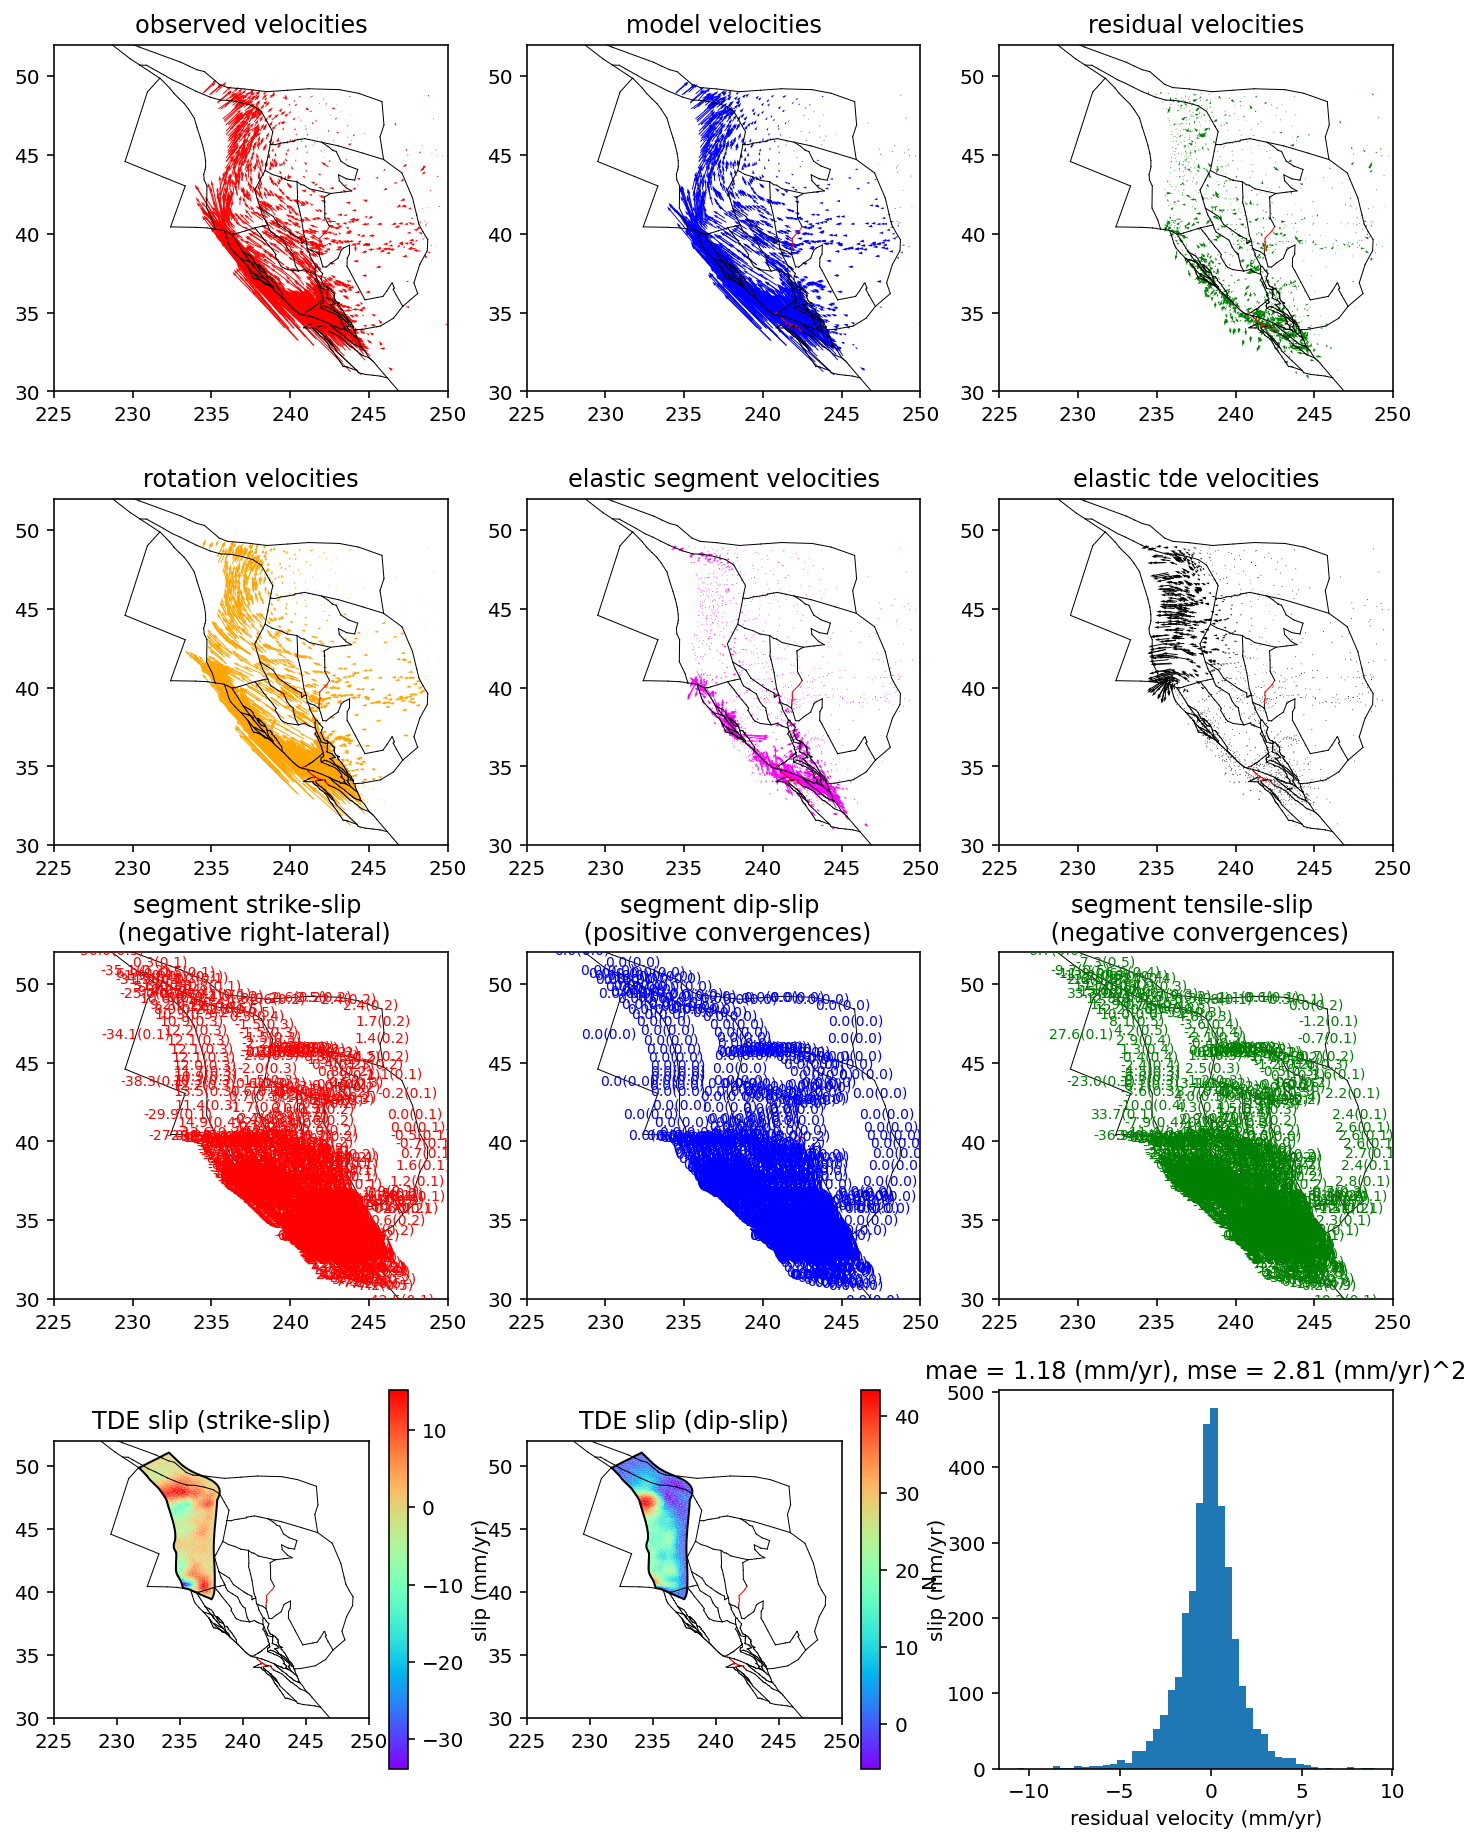

2023-12-28 20:13:36.145 | SUCCESS  | celeri.celeri:plot_estimation_summary:4585 - Wrote figures../runs/2023-12-28-20-13-21/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [9]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=1e2,
)

# Experiment: constrainted least squares
- The idea is to constrain TDE slip rates in some region

In [10]:
lower_bound = np.zeros_like(estimation.state_vector)
upper_bound = np.zeros_like(estimation.state_vector)
lower_bound[:] = -np.inf
upper_bound[:] = np.inf

# Strike-slip
lower_bound[index.start_tde_col[0] : index.end_tde_col[0] : 2] = -5
upper_bound[index.start_tde_col[0] : index.end_tde_col[0] : 2] = 5

# Dip-slip
lower_bound[index.start_tde_col[0] + 1 : index.end_tde_col[0] : 2] = 0
upper_bound[index.start_tde_col[0] + 1 : index.end_tde_col[0] : 2] = 30

In [11]:
from scipy.optimize import lsq_linear

# Non-linear solver (unbounded)
# res = lsq_linear(
#     estimation.operator * np.sqrt(estimation.weighting_vector[:, None]),
#     estimation.data_vector * np.sqrt(estimation.weighting_vector),
#     verbose=1,
# )

# Non-linear solver (bounded [-inf, inf])
res = lsq_linear(
    estimation.operator * np.sqrt(estimation.weighting_vector[:, None]),
    estimation.data_vector * np.sqrt(estimation.weighting_vector),
    bounds=(lower_bound, upper_bound),
    verbose=1,
)

import copy

estimation_bounded = copy.deepcopy(estimation)
estimation_bounded.state_vector = res.x
celeri.post_process_estimation(estimation_bounded, operators, station, index)

The relative change of the cost function is less than `tol`.
Number of iterations 37, initial cost 1.8383e+04, final cost 1.5643e+04, first-order optimality 4.91e+04.


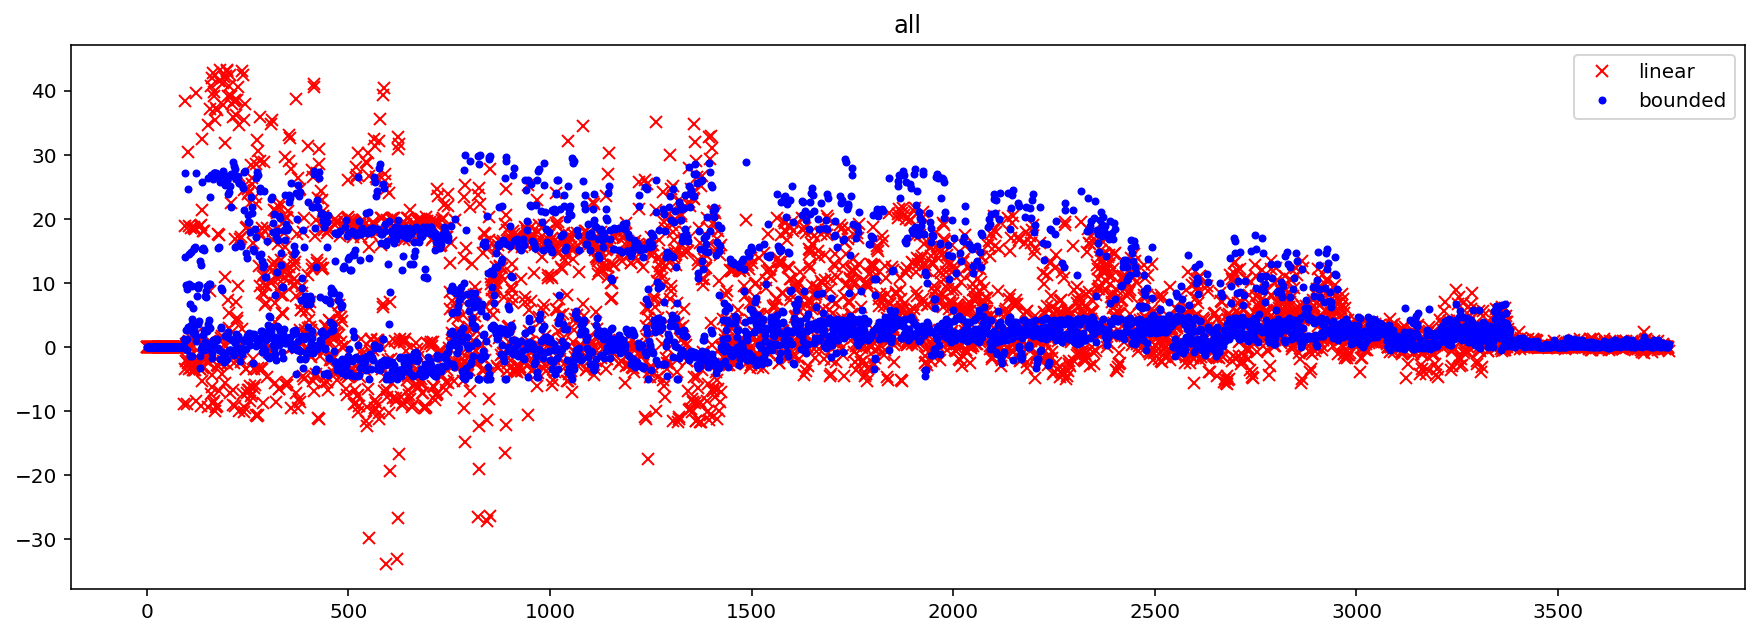

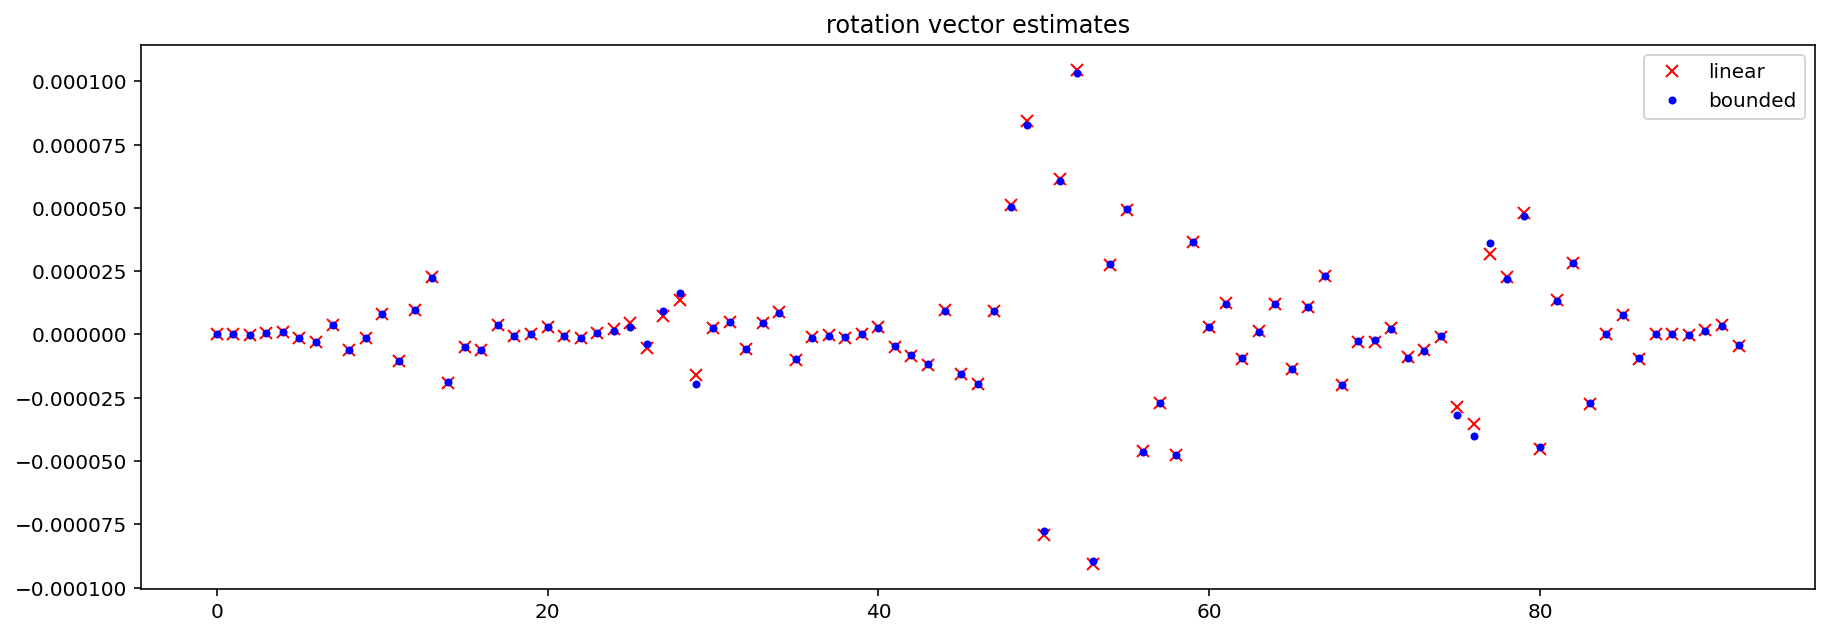

In [12]:
plt.figure(figsize=(15, 5))
plt.title("all")
plt.plot(estimation.state_vector, "xr", label="linear")
plt.plot(res.x, ".b", label="bounded")
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.title("rotation vector estimates")
plt.plot(estimation.state_vector[0 : 3 * index.n_blocks], "xr", label="linear")
plt.plot(res.x[0 : 3 * index.n_blocks], ".b", label="bounded")
plt.legend()
plt.show()

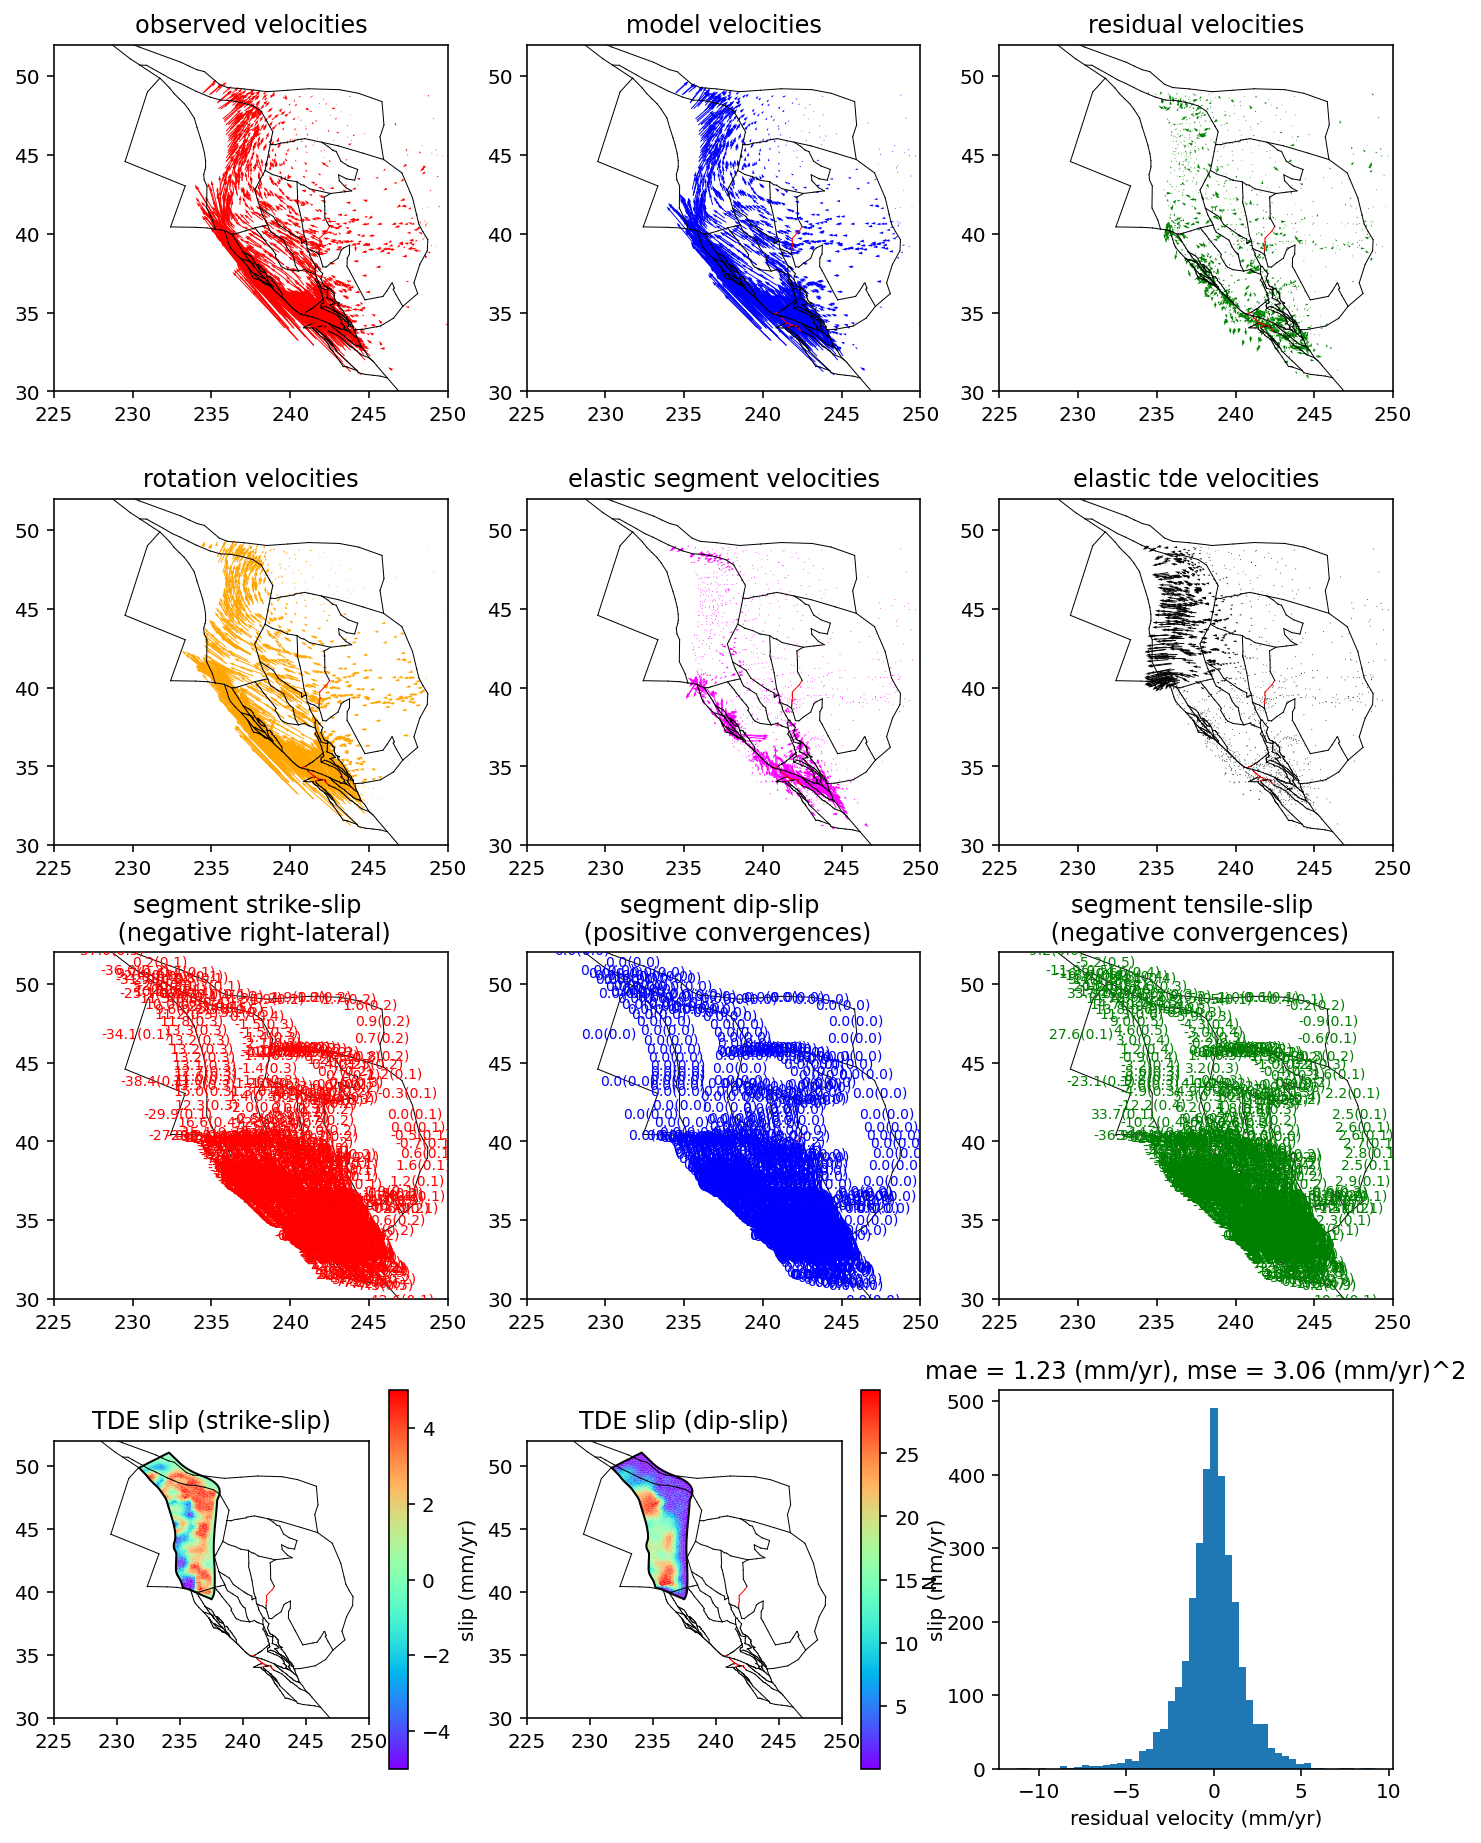

2023-12-28 20:16:35.250 | SUCCESS  | celeri.celeri:plot_estimation_summary:4585 - Wrote figures../runs/2023-12-28-20-13-21/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [13]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_bounded,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=1e2,
)

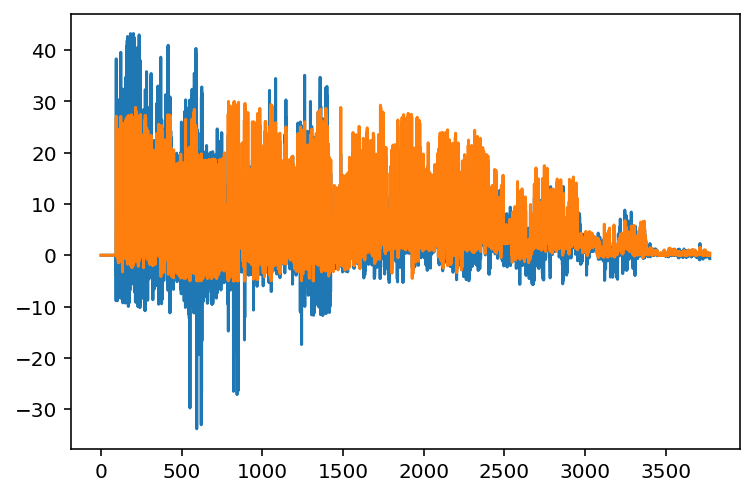

In [14]:
plt.plot(estimation.state_vector)
plt.plot(estimation_bounded.state_vector)

In [15]:
meshes[0].smoothing_weight

1e+16